In [6]:
import os

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import feature
from skimage import filters
from skimage.io import imread
import scipy

In [2]:
path_root = os.path.abspath(os.path.expanduser('dataset_voc/SegmentationClass'))
queue = [path_root]
npy_items = list()
while queue:
    ptr = queue.pop()
    for entry in os.scandir(ptr):
        if entry.name.startswith('.') or not entry.is_file():
            queue.append(entry.path)
        elif entry.name.endswith('.npy'):
            npy_items.append(entry.path)
npy_items.sort()
print(npy_items)

['/home/harny/Github/cell-classification/dataset_voc/SegmentationClass/hek293_100x_10.npy', '/home/harny/Github/cell-classification/dataset_voc/SegmentationClass/hek293_100x_100.npy', '/home/harny/Github/cell-classification/dataset_voc/SegmentationClass/hek293_100x_101.npy', '/home/harny/Github/cell-classification/dataset_voc/SegmentationClass/hek293_100x_102.npy', '/home/harny/Github/cell-classification/dataset_voc/SegmentationClass/hek293_100x_104.npy', '/home/harny/Github/cell-classification/dataset_voc/SegmentationClass/hek293_100x_108.npy', '/home/harny/Github/cell-classification/dataset_voc/SegmentationClass/hek293_100x_114.npy', '/home/harny/Github/cell-classification/dataset_voc/SegmentationClass/hek293_100x_116.npy', '/home/harny/Github/cell-classification/dataset_voc/SegmentationClass/hek293_100x_117.npy', '/home/harny/Github/cell-classification/dataset_voc/SegmentationClass/hek293_100x_118.npy']


In [3]:
path_root = os.path.abspath(os.path.expanduser('dataset_voc/JPEGImages'))
queue = [path_root]
jpg_items = list()
while queue:
    ptr = queue.pop()
    for entry in os.scandir(ptr):
        if entry.name.startswith('.') or not entry.is_file():
            queue.append(entry.path)
        elif entry.name.endswith('.jpg'):
            jpg_items.append(entry.path)
jpg_items.sort()
print(jpg_items)

['/home/harny/Github/cell-classification/dataset_voc/JPEGImages/hek293_100x_10.jpg', '/home/harny/Github/cell-classification/dataset_voc/JPEGImages/hek293_100x_100.jpg', '/home/harny/Github/cell-classification/dataset_voc/JPEGImages/hek293_100x_101.jpg', '/home/harny/Github/cell-classification/dataset_voc/JPEGImages/hek293_100x_102.jpg', '/home/harny/Github/cell-classification/dataset_voc/JPEGImages/hek293_100x_104.jpg', '/home/harny/Github/cell-classification/dataset_voc/JPEGImages/hek293_100x_108.jpg', '/home/harny/Github/cell-classification/dataset_voc/JPEGImages/hek293_100x_114.jpg', '/home/harny/Github/cell-classification/dataset_voc/JPEGImages/hek293_100x_116.jpg', '/home/harny/Github/cell-classification/dataset_voc/JPEGImages/hek293_100x_117.jpg', '/home/harny/Github/cell-classification/dataset_voc/JPEGImages/hek293_100x_118.jpg']


In [4]:
def preprocess(path):
    data = np.load(path)
    data[data > 0] = data[data > 0] + 1 # Class label + 1
    edge = filters.sobel(data) # Find edge
    data[edge > 0] = 1 # Set class 1 to edge
    return data

In [54]:
x = list()
y = list()
for train, label in zip(jpg_items, npy_items):
    t = imread(train)
    x.append(t)
    l = np.expand_dims(preprocess(label), axis=-1)
    y.append(l)

In [55]:
train_dataset = tf.data.Dataset.from_tensor_slices((x, y))

In [56]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [132]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=x[0].shape),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(3, 3, padding='same', activation='relu'),
#     tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same'),
#     tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same'),
#     tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same'),
])

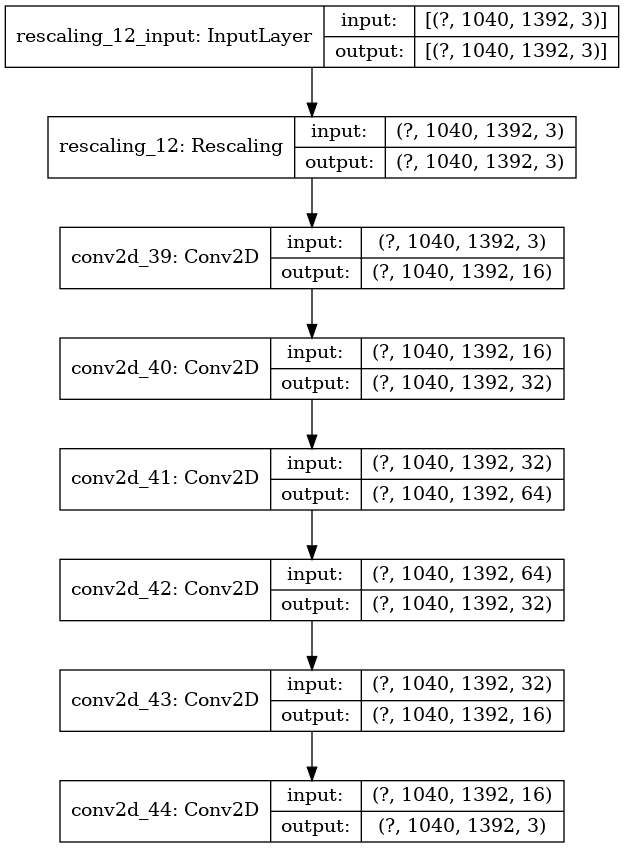

In [133]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [134]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=100)

Epoch 1/100


In [121]:
r = model.predict(np.expand_dims(x[3]/255, axis=0))

In [122]:
pred_mask = tf.argmax(r, axis=-1)

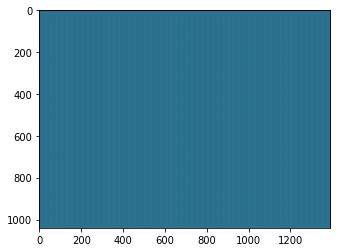

In [123]:
plt.imshow(pred_mask[0])